In [109]:
import ray.tune
import datasource
data = datasource.get_data()
from trainable_x_coord import Trainable
def define_searchspace(trial):
    model = trial.suggest_categorical('model', ['fsr_model.LSTM', 'fsr_model.CNN_LSTM', 'fsr_model.ANN'])
    if model == 'fsr_model.LSTM':
        trial.suggest_categorical('model_args/hidden_size', [8, 16, 32, 64, 128])
        trial.suggest_int('model_args/num_layer', 1, 8)
    elif model == 'fsr_model.CNN_LSTM':
        trial.suggest_categorical('model_args/cnn_hidden_size', [8, 16, 32, 64, 128])
        trial.suggest_categorical('model_args/lstm_hidden_size', [8, 16, 32, 64, 128])
        trial.suggest_int('model_args/cnn_num_layer', 1, 8)
        trial.suggest_int('model_args/lstm_num_layer', 1, 8)
    elif model == 'fsr_model.ANN':
        trial.suggest_categorical('model_args/hidden_size', [8, 16, 32, 64, 128])
        trial.suggest_int('model_args/num_layer', 1, 8)
    trial.suggest_categorical('criterion', ['torch.nn.MSELoss'])
    trial.suggest_categorical('optimizer', [
        'torch.optim.Adam',
        'torch.optim.NAdam',
        'torch.optim.Adagrad',
        'torch.optim.RAdam',
        'torch.optim.SGD',
    ])
    trial.suggest_float('optimizer_args/lr', 1e-5, 1e-1, log=True)
    imputer = trial.suggest_categorical('imputer', ['sklearn.impute.SimpleImputer'])
    if imputer == 'sklearn.impute.SimpleImputer':
        trial.suggest_categorical('imputer_args/strategy', [
            'mean',
            'median',
        ])
    trial.suggest_categorical('scaler', [
        'sklearn.preprocessing.StandardScaler',
        'sklearn.preprocessing.MinMaxScaler',
        'sklearn.preprocessing.RobustScaler',
    ])
import ray.tune
import ray.air
import ray.air.integrations.wandb
import ray.tune.schedulers
import datasource
from trainable_x_coord import Trainable
import ray.tune.search
import ray.tune.search.optuna

tuner = ray.tune.Tuner(
    trainable=ray.tune.with_resources(
        ray.tune.with_parameters(Trainable, data=datasource.get_data()),
        {'cpu':2},
    ),
    tune_config=ray.tune.TuneConfig(
        num_samples=-1,
        scheduler=ray.tune.schedulers.ASHAScheduler(
            max_t=100,
            grace_period=1,
            reduction_factor=2,
            brackets=1,
            metric='rmse',
            mode='min',
        ),
        search_alg=ray.tune.search.optuna.OptunaSearch(
            space=define_searchspace,
            metric='rmse',
            mode='min',
        ),
    ), 
    run_config=ray.air.RunConfig(
        callbacks=[
            ray.air.integrations.wandb.WandbLoggerCallback(project='FSR-prediction'),
        ],
        checkpoint_config=ray.air.CheckpointConfig(
            num_to_keep=3,
            checkpoint_score_attribute='rmse',
            checkpoint_score_order='min',
            checkpoint_frequency=5,
            checkpoint_at_end=True,
        ), 
    ),
)
checkpoint_path = '/home/seokj'\
'/ray_results/Trainable_2023-07-02_05-52-52/Trainable_f3bf0c19_74_criterion=torch_nn_MSELoss,model=fsr_model_LSTM,hidden_size=64,num_layer=2,optimizer=torch_optim_Adagrad,lr=_2023-07-02_06-17-19/checkpoint_000100'
ray.tune.Tuner.restore(Trainable, checkpoint_path)

[I 2023-07-03 11:16:26,132] A new study created in memory with name: optuna


AttributeError: type object 'Trainable' has no attribute 'decode'

In [131]:
from trainable import Trainable
experiment_path = '/home/seokj/ray_results/Trainable_2023-07-02_05-52-52'
restored_tuner: ray.tune.Tuner = ray.tune.Tuner.restore(experiment_path, Trainable)
result_grid: ray.tune.ResultGrid = restored_tuner.get_results()

Failed to read the results for 1 trials:
- /home/seokj/ray_results/Trainable_2023-07-02_05-52-52/Trainable_49f4caeb_1049_criterion=torch_nn_MSELoss,model=fsr_model_CNN_LSTM,cnn_hidden_size=16,cnn_num_layer=7,lstm_hidden_size=16_2023-07-02_10-25-01


In [132]:
best_result: ray.air.Result = result_grid.get_best_result(metric='rmse', mode='min')

In [155]:
best_result.config

{'model': 'fsr_model.LSTM',
 'model_args': {'hidden_size': 64, 'num_layer': 2},
 'criterion': 'torch.nn.MSELoss',
 'optimizer': 'torch.optim.Adagrad',
 'optimizer_args': {'lr': 0.02667400733687392},
 'scaler': 'sklearn.preprocessing.StandardScaler'}

In [156]:
from ray.train.torch import TorchPredictor
import fsr_model
TorchPredictor.from_checkpoint(best_result.checkpoint, fsr_model.LSTM(6, 64, 2, 6))

RuntimeError: No item with key: model is found in the Checkpoint. Make sure this key exists when saving the checkpoint in ``TorchTrainer``.

In [59]:
checkpoint_path = '/home/seokj'\
'/ray_results/Trainable_2023-07-02_05-52-52/Trainable_f3bf0c19_74_criterion=torch_nn_MSELoss,model=fsr_model_LSTM,hidden_size=64,num_layer=2,optimizer=torch_optim_Adagrad,lr=_2023-07-02_06-17-19/checkpoint_000100'

In [62]:
import torch
import fsr_model
model = fsr_model.LSTM(6, 64, 2, 6)
model.load_state_dict(torch.load(checkpoint_path + '/model.pth'))

<All keys matched successfully>

In [63]:
import ray.air.checkpoint
import ray.train.torch

checkpoint = ray.train.torch.TorchCheckpoint.from_model(model)
checkpoint.get_model()

LSTM(
  (encoder): LSTM(6, 64, num_layers=2)
  (decoder): Linear(in_features=64, out_features=6, bias=True)
)

In [64]:
from ray.train.torch import TorchPredictor
predictor = TorchPredictor.from_checkpoint(checkpoint)
predictor

TorchPredictor(model=LSTM(
  (encoder): LSTM(6, 64, num_layers=2)
  (decoder): Linear(in_features=64, out_features=6, bias=True)
), preprocessor=None, use_gpu=False)

In [70]:
import sklearn.preprocessing
import numpy as np
import datasource

data = datasource.get_data()
train_indexes, test_indexes = datasource.get_index_splited_by_time(data)
scaler_X = sklearn.preprocessing.StandardScaler()
scaler_y = sklearn.preprocessing.StandardScaler()

index_X = 'FSR_for_force'
index_y = 'force'
concated_train_indexes = np.concatenate(train_indexes)
scaler_X.fit(data.loc[concated_train_indexes, index_X])
scaler_y.fit(data.loc[concated_train_indexes, index_y])
data.loc[:, index_X] = scaler_X.transform(data.loc[:, index_X])
data.loc[:, index_y] = scaler_y.transform(data.loc[:, index_y])
train_dataset = datasource.FSRDataset(data.loc[:, index_X], data.loc[:, index_y], train_indexes)
test_dataset = datasource.FSRDataset(data.loc[:, index_X], data.loc[:, index_y], test_indexes)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None)

In [98]:
X, y = test_dataset[6]

In [99]:
pred = predictor.predict(X)['predictions']
pred = scaler_y.inverse_transform(pred)
y = scaler_y.inverse_transform(y)

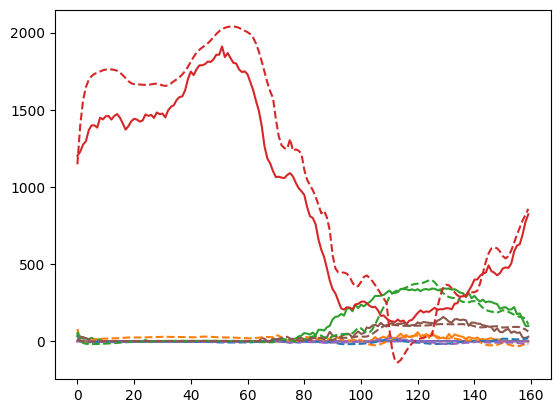

In [100]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
style = ax.plot(y, label=[1, 2, 3, 4, 5, 6])
for i in range(6):
    ax.plot(pred[:, i], color=style[i].get_color(), linestyle='--')